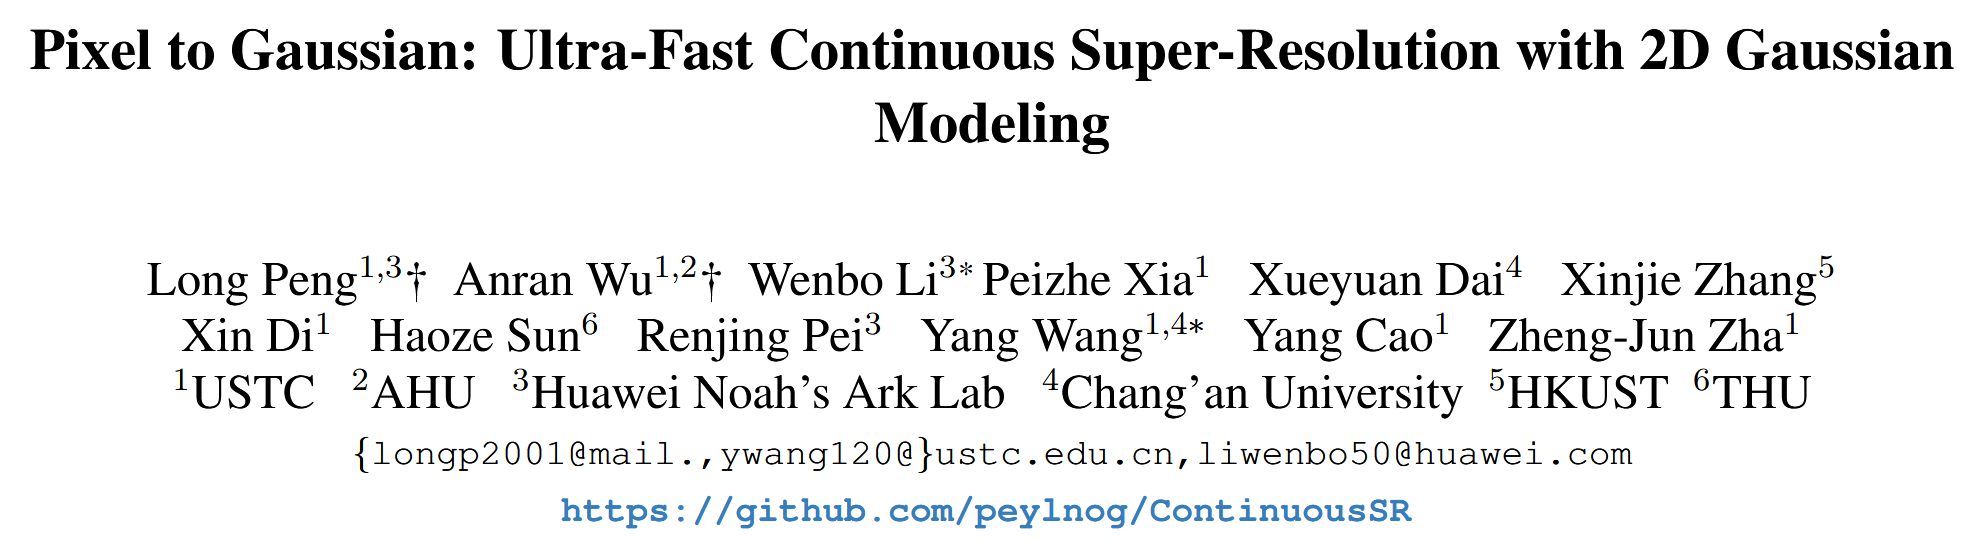

# Pixel to Gaussian: Ultra-Fast Continuous Super-Resolution with 2D Gaussian Modeling  
**Long Peng, Anran Wu, Wenbo Li, Peizhe Xia, Xueyuan Dai, Xinjie Zhang, Xin Di, Haoze Sun, Renjing Pei, Yang Wang, Yang Cao, Zheng-Jun Zha**  
Affiliations: USTC, Huawei Noah’s Ark Lab, HKUST, THU, etc.  
Published at: CVPR 2025 (arXiv:2503.06617v1)

---

## 1. Background

Super-resolution (SR) aims to recover a high-resolution (HR) image from its low-resolution (LR) counterpart. Traditional SR methods focus on fixed integer scales like ×2, ×3, or ×4, which limits flexibility in real applications.  

To solve this, **Arbitrary-Scale Super-Resolution (ASSR)** was proposed. A landmark method, **LIIF** [Chen et al., 2021], introduces *implicit neural representation (INR)* to map coordinates to RGB values via an MLP. Given any continuous coordinate $(x, y)$, the network outputs the corresponding color, enabling continuous upscaling.

However, such INR-based methods suffer from:

- Inefficiency: each pixel requires repeated querying and decoding.
- Limited fidelity: coordinate-based MLPs struggle to capture high-frequency textures.
- Complex pipeline: involves multiple upsampling-decoding stages.

In essence, while INR methods can do continuous SR, they do so **slowly** and **with limited detail reconstruction**.

---

## 2. The Core Idea

This paper proposes a fundamentally new idea:  
Instead of **learning a function to query pixels**, learn to **explicitly construct a continuous image field**, represented by a set of 2D **Gaussian kernels**.

Each kernel is parameterized by its spatial position $\mu$, covariance matrix $\Sigma$, and RGB color $c_{rgb}$. The reconstructed image is the sum of $N$ such Gaussians:

$$
f_c(x, y) = \sum_{i=1}^N G_i(x, y)
$$

Each Gaussian kernel $G_i$ is defined as:

$$
G_i(x, y, c_{rgb}, \Sigma) = c_{rgb} \cdot \frac{1}{2\pi |\Sigma|} \exp \left( -\frac{1}{2} d^T \Sigma^{-1} d \right)
$$

where $d = \begin{bmatrix} x - \mu_x \\ y - \mu_y \end{bmatrix}$.

The covariance matrix is:

$$
\Sigma = \begin{bmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\
\rho \sigma_x \sigma_y & \sigma_y^2
\end{bmatrix}
$$

### Why not directly predict Gaussians from LR?

Directly learning these parameters is hard — the space is sensitive and high-dimensional. Even small errors in $\mu$ or $\Sigma$ can lead to large perceptual distortions.

To address this, the authors propose:

#### a. **Deep Gaussian Prior (DGP):**  
Analyze 40,000 natural images to uncover statistical priors on $\sigma_x^2$, $\sigma_y^2$, and $\rho$.  
Result: Most values fall in compact Gaussian-distributed ranges (e.g., $\sigma^2 \in [0, 2.4]$).

#### b. **DGP-Driven Covariance Weighting (DDCW):**  
Instead of learning $\Sigma$ from scratch, learn weights to combine pre-defined covariances sampled from the DGP distribution:

$$
\sigma_{i,x}^2, \sigma_{i,y}^2 \sim P(\sigma^2), \quad \rho_i \sigma_{i,x} \sigma_{i,y} \sim P(\rho \sigma_x \sigma_y)
$$

Then construct a target kernel by weighted sum:

$$
G_{\text{target}} = \sum_{i=1}^N w_i \cdot G_i
$$

#### c. **Adaptive Position Drifting (APD):**  
Learn position offsets $\Delta \mu$ from the LR image feature map, rather than fixing kernel centers:

$$
P_{\text{final}} = P_{\text{init}} + \tanh(\text{MLP}(F_{LR}))
$$

This helps concentrate Gaussians in textured regions.

---

## 3. Contributions

- Propose **ContinuousSR**, the first to reconstruct 2D continuous signals explicitly from LR images using 2D Gaussian splatting.
- Discover **Deep Gaussian Prior (DGP)** and propose **DGP-Driven Covariance Weighting (DDCW)** to simplify optimization.
- Introduce **Adaptive Position Drifting (APD)** to dynamically place kernels based on image content.
- Achieve **19.5× speedup** and **+0.9 dB PSNR gain** over previous SOTA (e.g., CiaoSR, LIIF) on multiple benchmarks.

---

## 4. References

[1] Chen et al. "Learning Continuous Image Representation with Local Implicit Image Function." CVPR, 2021.  
[2] Peng et al. "Pixel to Gaussian: Ultra-Fast Continuous Super-Resolution with 2D Gaussian Modeling." CVPR, 2025.  
[3] Cao et al. "CiaoSR: Continuous Implicit Attention-in-Attention Network for ASSR." CVPR, 2023.  
[4] Zhang et al. "GaussianImage: High-Fidelity 2D Gaussian Splatting for SR." ECCV, 2024.  


The training code has not been released yet; only the pre-trained model and the testing code have been provided for evaluation.  

In [12]:
import argparse
import os
import math
from functools import partial

import yaml
import torch
from torchvision import transforms
from PIL import Image

import numpy as np
import datasets
import models
import matplotlib.pyplot as plt

import utils
from utils import make_coord
from torchvision.utils import save_image
parser = argparse.ArgumentParser()
parser.add_argument('--input', type=str, default='/home/xqgao/2025/MIT/code/GS/ContinuousSR-main/butterflyx4.png', help='Input image file')
parser.add_argument('--model', type=str, default='/home/xqgao/2025/MIT/code/GS/ContinuousSR-main/ContinuousSR.pth', help='Path to the model file')
parser.add_argument('--scale', type=str, default='4,4', help='Scaling factors for the image (default: 4,4)')
parser.add_argument('--output', type=str, default='/home/xqgao/2025/MIT/code/GS/ContinuousSR-main/output.png', help='Output image file')
parser.add_argument('--gpu', type=str, default='0', help='GPU index to use (default: 0)')
args = parser.parse_args([])

os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu


/tmp/ipykernel_3534998/3970855738.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_spec = torch.load(args.model)['model']


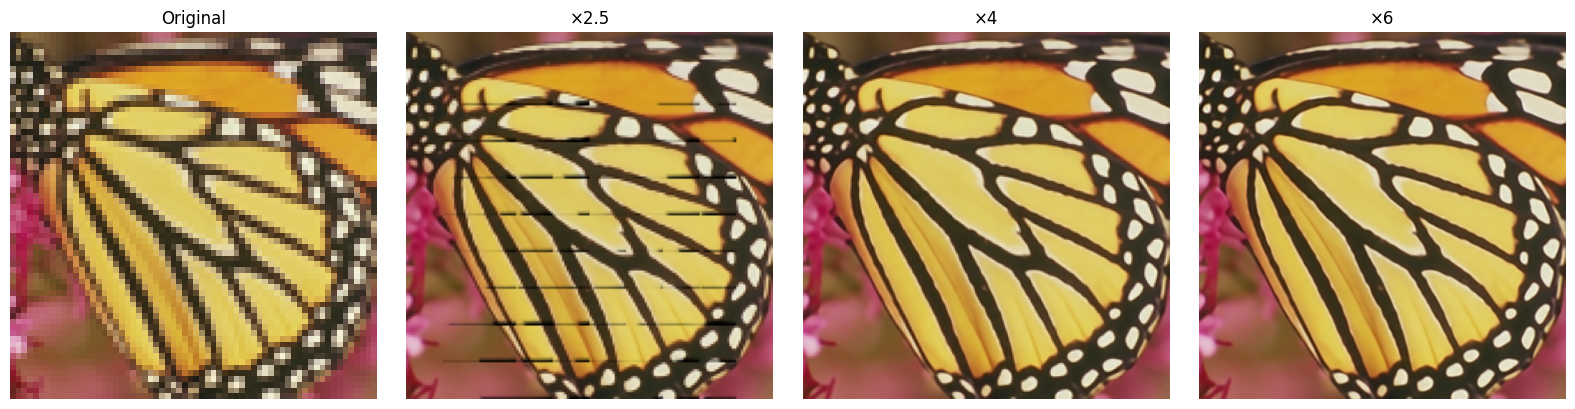

In [13]:
# Load image and model
img = transforms.ToTensor()(Image.open(args.input).convert('RGB')).cuda()
model_spec = torch.load(args.model)['model']
model = models.make(model_spec, load_sd=True).cuda()

# Prepare scales
scales = [(1, 1), (2.5, 2.5), (4, 4), (6, 6)]  # you can add more scales
titles = ["Original", "×2.5", "×4", "×6"]
results = []

# Predict and store each scale result
with torch.no_grad():
    for s in scales:
        scale_tensor = torch.tensor([[s[0], s[1]]]).float().cuda()
        pred = model(img.unsqueeze(0), scale_tensor).squeeze(0)
        pred = pred.clamp(0, 1).cpu()
        results.append(transforms.ToPILImage()(pred))

# Also include original image for comparison
original_img = transforms.ToPILImage()(img.cpu())
results[0] = original_img  # ensure original is first

# Plot all results
plt.figure(figsize=(16, 4))
for i, (title, image) in enumerate(zip(titles, results)):
    plt.subplot(1, len(scales), i + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Model Architecture: ContinuousGaussian (Implementation Overview)

In this section, we break down the architecture of `ContinuousGaussian`, the model used to implement the ContinuousSR framework proposed in *Pixel to Gaussian: Ultra-Fast Continuous Super-Resolution with 2D Gaussian Modeling (CVPR 2025)*.

This model transforms a low-resolution (LR) image into a continuous high-resolution (HR) signal using **2D Gaussian kernels**, as proposed in the Pixel-to-Gaussian paradigm.

---

### 🔧 1. Feature Extraction

The model begins with a CNN encoder (`self.encoder`) to extract low-resolution features from the input image $I_{LR}$. Then, a `PixelUnshuffle` operation increases the number of channels and prepares feature vectors for dense prediction. This gives us:

$$
F_{LR} = E(I_{LR})
$$

where $E(\cdot)$ is the encoder and $F_{LR}$ is the processed feature tensor.

---

### 🟢 2. Color Prediction (MLP)

A multilayer perceptron `self.mlp` predicts the RGB values of each 2D Gaussian kernel from the encoded features:

$$
c_{\text{rgb}} = \text{MLP}(F_{LR})
$$

This corresponds to the color component $c_{rgb}$ in the Gaussian kernel definition:

$$
G_i(x, y) = c_{rgb} \cdot \frac{1}{2\pi |\Sigma|} \exp \left( -\frac{1}{2} (d^\top \Sigma^{-1} d) \right)
$$

---

### 🟡 3. Covariance Estimation via Deep Gaussian Prior (DGP)

Instead of directly regressing the sensitive covariance matrix $\Sigma$, the model performs a **learned soft combination** of pre-sampled kernels from the **Deep Gaussian Prior (DGP)**.

- The dictionary `self.gau_dict` contains pre-sampled triplets of $(\sigma_x^2, \sigma_y^2, \rho)$.
- A learned feature embedding is matched with a trainable set of Gaussian embeddings using:

$$
G_{\text{target}} = \sum_{i=1}^N w_i \cdot G_i, \quad \text{where } w_i = \text{softmax}(\text{MLP}(F_{LR}))
$$

This is the **DGP-Driven Covariance Weighting** (DDCW) module described in the paper.

---

### 🔴 4. Adaptive Position Drifting (APD)

To accurately determine the spatial position $\mu$ of each Gaussian kernel, the model introduces **Adaptive Position Drifting (APD)**. This is a learned offset applied to the fixed LR pixel grid:

$$
\mu = \mu_{\text{init}} + \Delta\mu, \quad \Delta\mu = \tanh(\text{MLP}_{\text{offset}}(F_{LR}))
$$

This allows the network to place more kernels in texture-rich areas, improving spatial fidelity.

---

### 🎯 5. Rendering with 2D Gaussian Splatting

Once the Gaussian parameters $(\mu, \Sigma, c_{rgb})$ are estimated, the model **projects** and **rasterizes** them into a 2D canvas at arbitrary resolution $(H, W)$ using Gaussian splatting:

- Project each Gaussian kernel into the HR grid.
- Aggregate their contributions using rasterization.

This yields the final continuous super-resolved image:

$$
I_{HR}(x, y) = \sum_i G_i(x, y)
$$

The rendering pipeline avoids time-consuming upsampling and decoding, achieving **real-time speed** and **continuous zoom**.

---

### 📌 Summary

| Module | Function | Paper Component |
|--------|----------|------------------|
| `encoder` | Feature extraction | $F_{LR} = E(I_{LR})$ |
| `mlp` | RGB prediction | $c_{rgb} = \text{MLP}(F)$ |
| `mlp_vector` + `gau_dict` | Covariance weighting | DGP-Driven Covariance Weighting |
| `mlp_offset` | Position offset | Adaptive Position Drifting |
| `project_gaussians_2d` + `rasterize_gaussians_sum` | Rendering | 2D Gaussian Splatting |

The entire model replaces pixel-wise MLP query (e.g., LIIF) with **explicit Gaussian construction + fast rasterization**, improving both performance and efficiency.

---